In [4]:
import gym
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.sac import MlpPolicy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [ ]:
# Define the network architectures - orignial models

env = gym.make("MountainCarContinuous-v0")

networks = [
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[8], qf=[8])),
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[16], qf=[16])),
    
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[32, 32], qf=[32, 32])),
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[64, 64], qf=[64, 64])),
    
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[128, 128], qf=[128, 128])),
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[256, 256, 256], qf=[256, 256, 256]))
]

In [3]:
# Modified orignial models

env = gym.make("MountainCarContinuous-v0")

networks = [
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[32], qf=[32])),
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[64], qf=[64])),

    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[32, 64], qf=[32, 64])),
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[64, 128], qf=[64, 128])),
    
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[32, 64, 128], qf=[32, 64, 128])),
    dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[64, 128, 256], qf=[64, 128, 256]))
]

In [5]:
# Define the function to train an SAC agent with network architecture above
def train_sac_with_network(network, env, log_dir, total_timesteps=25000): # Change to 50000 for the orignial models
    monitored_env = Monitor(env, log_dir)
    model = SAC(MlpPolicy,monitored_env,policy_kwargs=network,verbose=1)
    model.learn(total_timesteps=total_timesteps)
    return model

In [4]:
log_dir = "log_dir_1"
os.makedirs(log_dir, exist_ok=True)
model = train_sac_with_network(networks[0], env, log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -33.6    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 121      |
|    time_elapsed    | 32       |
|    total_timesteps | 3996     |
| train/             |          |
|    actor_loss      | -5.37    |
|    critic_loss     | 0.00255  |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3895     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -31.4    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 123      |
|    time_elapsed    | 64       |
|    total_timesteps | 7992     |
| train/             |          |
|    actor_loss      | -5.74 

In [5]:
log_file_example = os.path.join("log_dir_1", "monitor.csv")
monitor_data_example = np.genfromtxt(log_file_example, delimiter=',', skip_header=1, names=True)
print(monitor_data_example.dtype.names)

('r', 'l', 't')


In [6]:
# Train the SAC agent with each network architecture, save the models, and save the training rewards
rewards = []

for i, network in enumerate(networks):
    log_dir = f"log_dir_{i+1}"
    os.makedirs(log_dir, exist_ok=True)
    
    model = train_sac_with_network(network, env, log_dir)
    model.save(f'model_{i+1}')
    
    log_file = os.path.join(log_dir, "monitor.csv")
    monitor_data = np.genfromtxt(log_file, delimiter=',', skip_header=1, names=True)
    
    reward = monitor_data['r']
    rewards.append(reward)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -34.5    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 125      |
|    time_elapsed    | 31       |
|    total_timesteps | 3996     |
| train/             |          |
|    actor_loss      | -5.38    |
|    critic_loss     | 0.00232  |
|    ent_coef        | 0.31     |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3895     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -32      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 122      |
|    time_elapsed    | 65       |
|    total_timesteps | 7992     |
| train/             |          |
|    actor_loss      | -5.67 

In [6]:
# Define the function to evaluate an SAC agent with a given network architecture
def evaluate(model, env, num_episodes=100): # Use 100 episodes
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)
    return np.mean(rewards), np.std(rewards)

In [7]:
# Evaluate each trained network and calculate the average reward and standard deviation
avg_rewards = []
std_devs = []

for i, network in enumerate(networks):
    log_dir = f"log_dir_{i}"
    model = SAC.load(f'model_{i+1}')
    avg_reward, std_dev = evaluate(model, env)
    avg_rewards.append(avg_reward)
    std_devs.append(std_dev)
    print(f'Network {i+1}: Average Reward = {avg_reward:.5f}, Standard Deviation = {std_dev:.5f}')

Network 1: Average Reward = -0.09792, Standard Deviation = 0.00080
Network 2: Average Reward = -0.13555, Standard Deviation = 0.02172
Network 3: Average Reward = -0.01376, Standard Deviation = 0.00076
Network 4: Average Reward = -0.00013, Standard Deviation = 0.00008
Network 5: Average Reward = -0.00122, Standard Deviation = 0.00006
Network 6: Average Reward = -0.00623, Standard Deviation = 0.00210


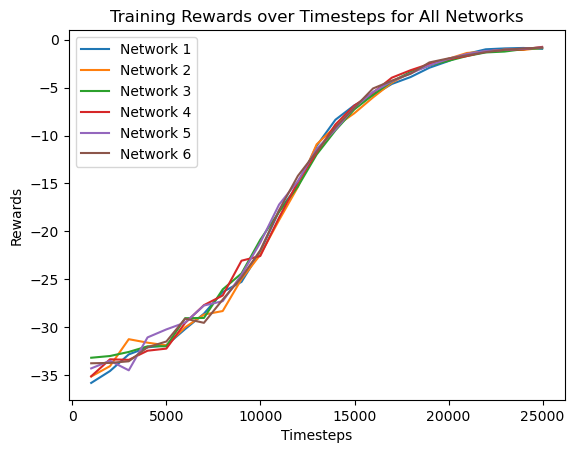

In [8]:
def plot_rewards(log_folders, network_labels, title="Training Rewards"):
    for log_folder, label in zip(log_folders, network_labels):
        x, y = ts2xy(load_results(log_folder), "timesteps")
        plt.plot(x, y, label=label)
    
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title(title)
    plt.legend()

    plt.savefig('ann_1.png', dpi=300, bbox_inches='tight')
    plt.show()

log_folders = [f"log_dir_{i+1}" for i in range(len(networks))]
network_labels = [f'Network {i+1}' for i in range(len(networks))]
plot_rewards(log_folders, network_labels, title="Training Rewards over Timesteps for All Networks")

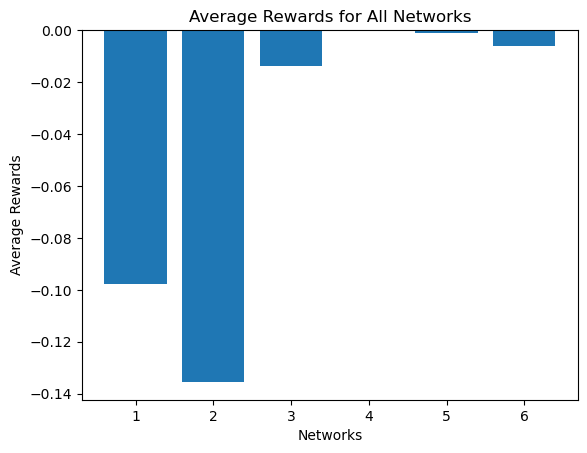

In [9]:
# Plot Average Rewards
network_labels = [f"{i + 1}" for i in range(len(networks))]

plt.bar(network_labels, avg_rewards)
plt.xlabel("Networks")
plt.ylabel("Average Rewards")
plt.title("Average Rewards for All Networks")
plt.savefig('ann_2.png', dpi=300, bbox_inches='tight')
plt.show()

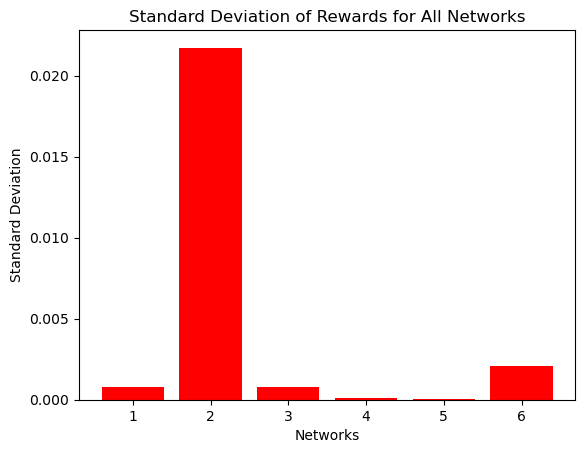

In [10]:
# Plot Standard Deviation of Rewards
plt.bar(network_labels, std_devs, color='red')
plt.xlabel("Networks")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation of Rewards for All Networks")
plt.savefig('ann_3.png', dpi=300, bbox_inches='tight')
plt.show()